In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
from pykalman import KalmanFilter

In [3]:
# Import function to create training and test set splits
from sklearn.model_selection import train_test_split
# Import function to automatically create polynomial features! 
from sklearn.preprocessing import PolynomialFeatures
# Import Linear Regression and a regularized regression function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
# Finally, import function to make a machine learning pipeline
from sklearn.pipeline import make_pipeline

In [4]:
df = pd.read_csv('../temp_data/histData.csv')

## Delta and Drift

In [5]:
delta = (df.close - df.close.shift(1)) * 10000

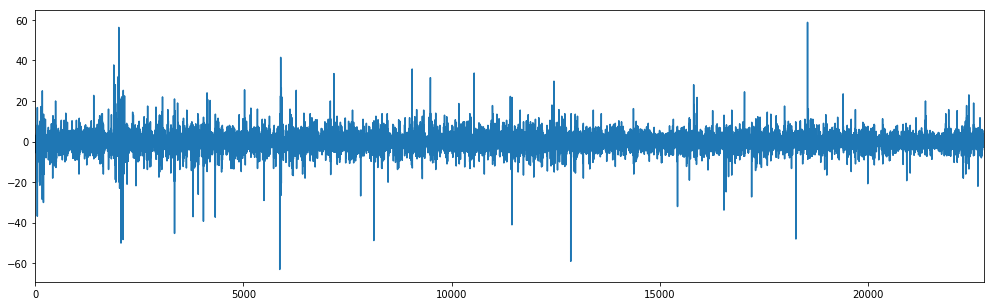

In [6]:
delta.plot(figsize=(17,5));

In [7]:
drift = delta.rolling(window=480).sum()

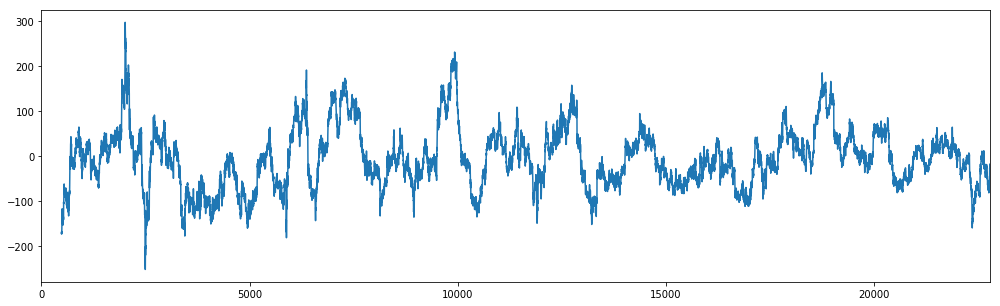

In [8]:
drift.plot(figsize=(17,5));

In [154]:
delta_a = (df.close - df.close.shift(480)) * 10000

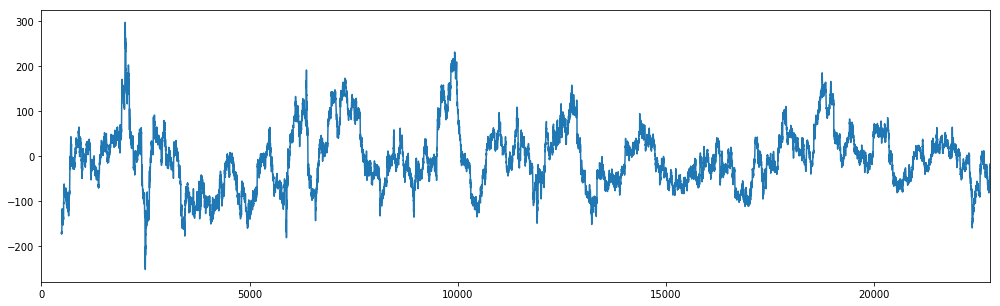

In [155]:
delta_a.plot(figsize=(17,5));

In [152]:
drift_a = delta_a.rolling(window=480).sum()

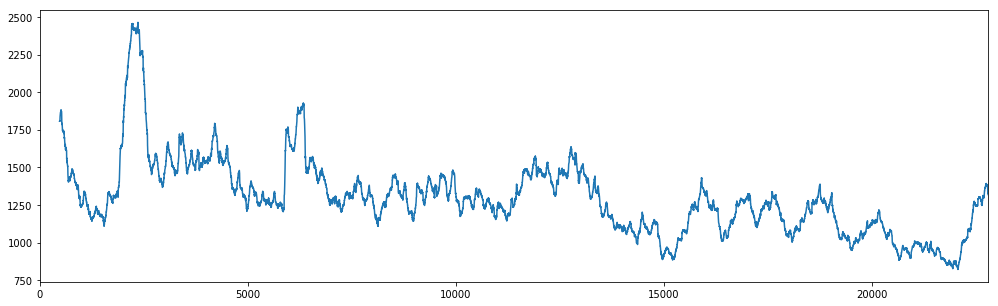

In [153]:
drift_a.plot(figsize=(17,5));

In [9]:
drift.mean()

-4.464540278836271

In [10]:
drift_standard = drift - drift.rolling(window=480).mean()

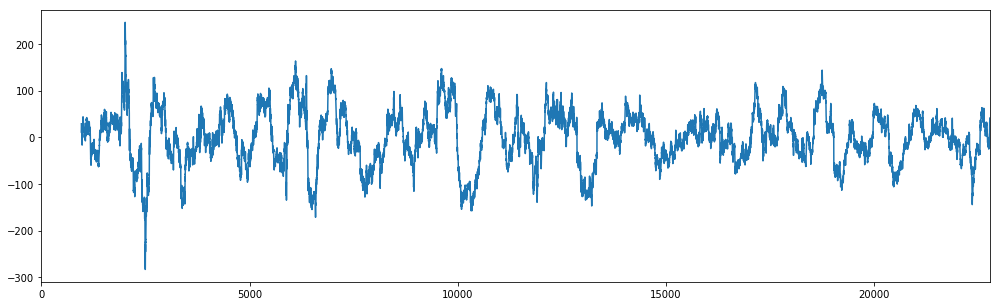

In [11]:
drift_standard.plot(figsize=(17,5));

In [12]:
drift_standard.mean()

-0.443618908817883

## Volatility

In [12]:
highLow = (df.high - df.low) * 10000

In [13]:
vol = highLow.rolling(window=480).mean()

In [17]:
vol = drift.rolling(window=480).std()

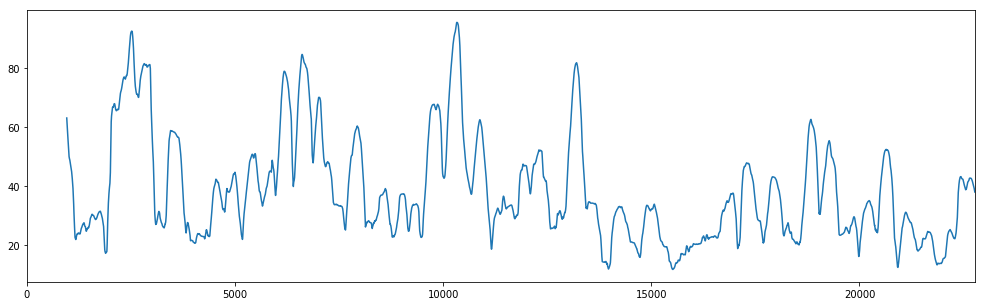

In [18]:
vol.plot(figsize=(17,5));

In [19]:
driftVol = drift_standard/ vol

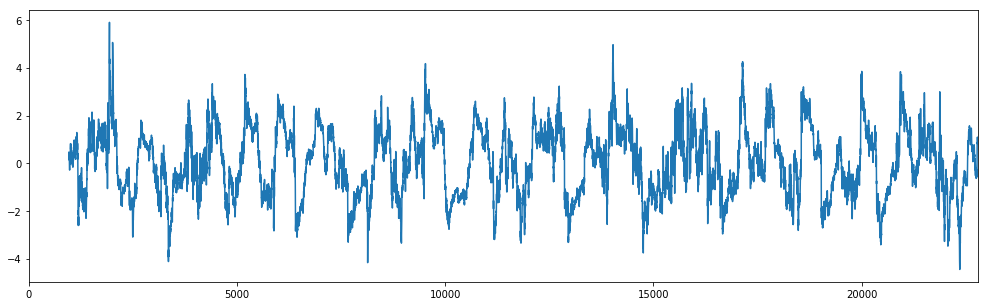

In [20]:
driftVol.plot(figsize=(17,5));

In [25]:
df1 = df.assign(drift_standard = drift_standard)
df2 = df1.assign(vol = vol)
df3 = df2.assign(drift = drift)

In [38]:
df3 = df3.dropna()

In [39]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[df3.drift], [np.ones(len(df3.vol))]]).T, axis=1)

In [40]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2,2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

In [41]:
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(df3.drift.values)

Text(0,0.5,'Drift')

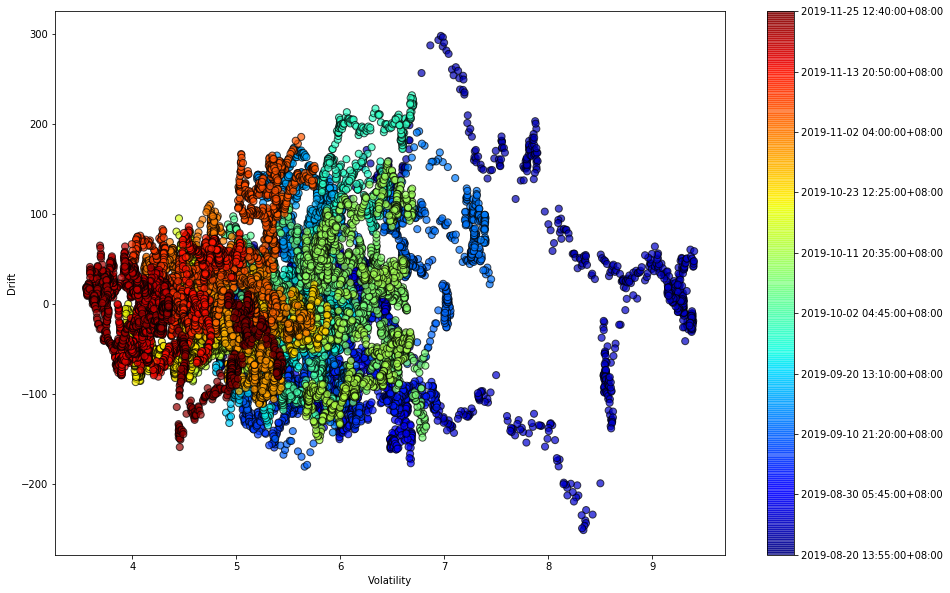

In [44]:
# visualize the correlation between assest prices over time
fig = plt.figure(figsize=(15,10));
cm = plt.cm.get_cmap('jet')
dates = [p for p in df3['date'][::len(df3['date'])//10]]
colors = np.linspace(0.1, 1, len(df3))
sc = plt.scatter(df3.vol, df3.drift, s=50, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in df3['date'][::len(df3['date'])//10]]);
plt.xlabel('Volatility')
plt.ylabel('Drift')

# # add regression lines
# step = 5
# xi = np.linspace(df3.vol.min(), df3.vol.max(), 2)
# colors_l = np.linspace(0.1, 1, len(state_means[::step]))
# for i, beta in enumerate(state_means[::step]):
#     plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

In [47]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[df3.drift_standard], [np.ones(len(df3.vol))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2,2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(df3.drift_standard.values)

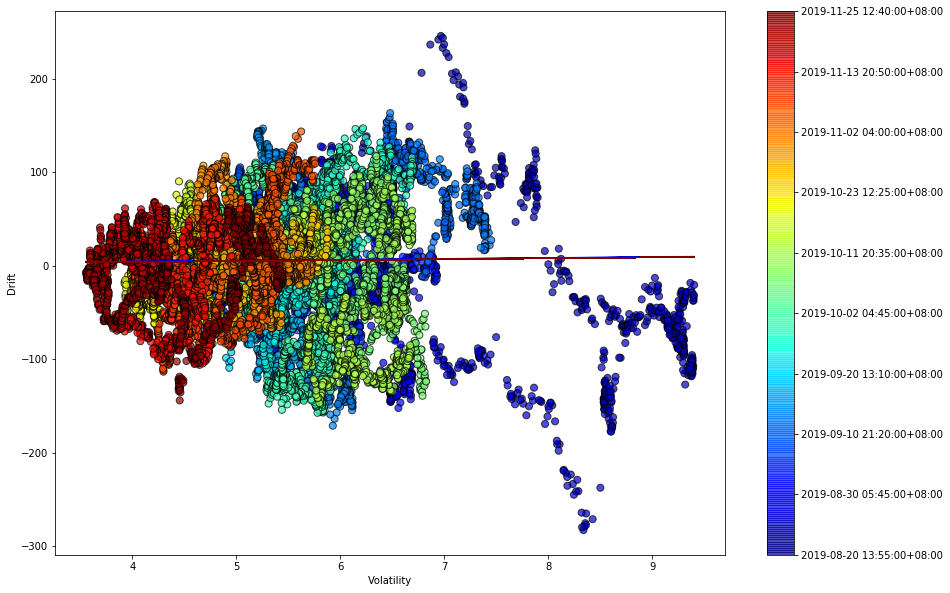

In [48]:
# visualize the correlation between assest prices over time
fig = plt.figure(figsize=(15,10));
cm = plt.cm.get_cmap('jet')
dates = [p for p in df3['date'][::len(df3['date'])//10]]
colors = np.linspace(0.1, 1, len(df3))
sc = plt.scatter(df3.vol, df3.drift_standard, s=50, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in df3['date'][::len(df3['date'])//10]]);
plt.xlabel('Volatility')
plt.ylabel('Drift')

# add regression lines
step = 5
xi = np.linspace(df3.vol.min(), df3.vol.max(), 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

## Regression

In [49]:
df3.tail()

,date,open,high,low,close,volume,drift_standard,vol,drift
22782,2019-12-05 04:30:00+08:00,1.617000,1.617175,1.616900,1.617100,-1,38.902604,5.248437,-19.50
22783,2019-12-05 04:35:00+08:00,1.617100,1.617275,1.616975,1.616975,-1,41.591667,5.244271,-16.75
22784,2019-12-05 04:40:00+08:00,1.616975,1.617050,1.616725,1.616800,-1,38.292708,5.242187,-20.00
22785,2019-12-05 04:45:00+08:00,1.616800,1.616900,1.616725,1.616800,-1,35.256250,5.232292,-23.00
22786,2019-12-05 04:50:00+08:00,1.616800,1.616950,1.616750,1.616800,-1,33.727083,5.228125,-24.50


In [54]:
drift_ahead = df3.drift.shift(-480)

In [55]:
df4 = df3.assign(drift_ahead = drift_ahead)

In [56]:
df4.tail()

,date,open,high,low,close,volume,drift_standard,vol,drift,drift_ahead
22782,2019-12-05 04:30:00+08:00,1.617000,1.617175,1.616900,1.617100,-1,38.902604,5.248437,-19.50,NaN
22783,2019-12-05 04:35:00+08:00,1.617100,1.617275,1.616975,1.616975,-1,41.591667,5.244271,-16.75,NaN
22784,2019-12-05 04:40:00+08:00,1.616975,1.617050,1.616725,1.616800,-1,38.292708,5.242187,-20.00,NaN
22785,2019-12-05 04:45:00+08:00,1.616800,1.616900,1.616725,1.616800,-1,35.256250,5.232292,-23.00,NaN
22786,2019-12-05 04:50:00+08:00,1.616800,1.616950,1.616750,1.616800,-1,33.727083,5.228125,-24.50,NaN


In [57]:
df5 = df4.dropna()

In [58]:
df5.tail()

,date,open,high,low,close,volume,drift_standard,vol,drift,drift_ahead
22302,2019-12-03 12:15:00+08:00,1.619525,1.619575,1.61890,1.61905,-1,-37.229167,4.481250,-41.25,-19.50
22303,2019-12-03 12:20:00+08:00,1.619050,1.619050,1.61855,1.61865,-1,-41.874479,4.485937,-46.00,-16.75
22304,2019-12-03 12:25:00+08:00,1.618650,1.619075,1.61865,1.61880,-1,-39.284375,4.487500,-43.50,-20.00
22305,2019-12-03 12:30:00+08:00,1.618800,1.619350,1.61870,1.61910,-1,-36.205208,4.490104,-40.50,-23.00
22306,2019-12-03 12:35:00+08:00,1.619100,1.619350,1.61895,1.61925,-1,-34.134896,4.493229,-38.50,-24.50


In [66]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[df5.drift_ahead], [np.ones(len(df5.drift_standard))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2,2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(df5.drift_ahead.values)

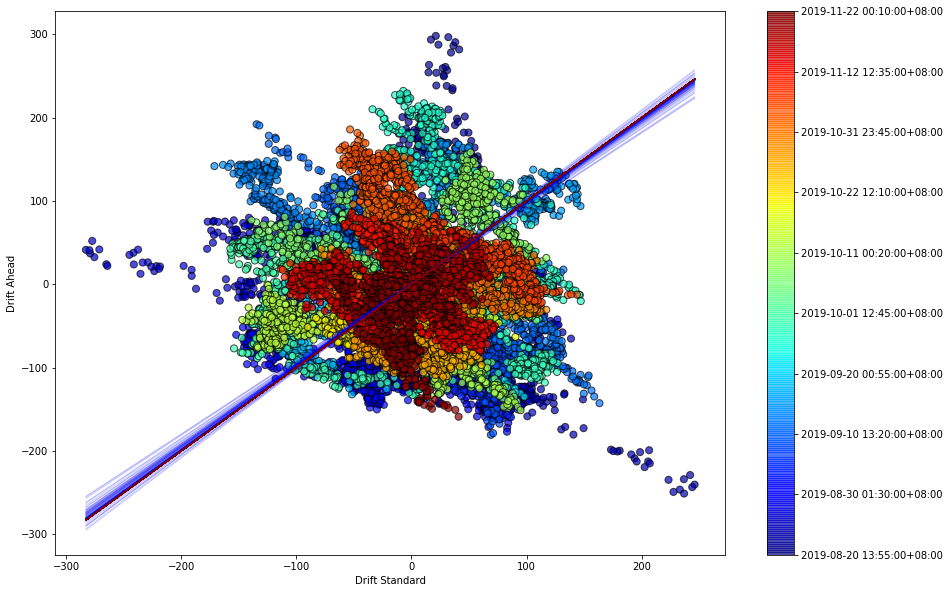

In [67]:
# visualize the correlation between assest prices over time
fig = plt.figure(figsize=(15,10));
cm = plt.cm.get_cmap('jet')
dates = [p for p in df5['date'][::len(df5['date'])//10]]
colors = np.linspace(0.1, 1, len(df5))
sc = plt.scatter(df5.drift_standard, df5.drift_ahead, s=50, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in df5['date'][::len(df5['date'])//10]]);
plt.xlabel('Drift Standard')
plt.ylabel('Drift Ahead')

# add regression lines
step = 5
xi = np.linspace(df5.drift_standard.min(), df5.drift_standard.max(), 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

In [192]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(np.array(df5[['drift', 'vol']]).reshape(-1,2),
                                                    np.array(df5['drift_ahead']),test_size=0.3)
degreeHolder = []
rmseHolder = []
scoreHolder = []
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    degreeHolder.append(degree)
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    rmseHolder.append(RMSE)
    test_score = model.score(X_test,y_test)
    scoreHolder.append(test_score)
    
    # to save the model
    pkl_filename = "models/model_"+str(degree)+".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

In [193]:
outputDF = pd.DataFrame({'degree': degreeHolder, 'rmse': rmseHolder, 'r2':scoreHolder})
outputDF

,degree,rmse,r2
0,2,5318.206220,0.032445
1,3,5223.183825,0.066712
2,4,5200.711011,0.074725
3,5,5177.831111,0.082849
4,6,5165.196578,0.087319
5,7,5159.209731,0.089434
6,8,5155.884766,0.090607


In [123]:
RMSE

5315.8268251179525

In [124]:
test_score

0.04108273085855474

In [140]:
drift_s_ahead = df3.drift_standard.shift(-480)

In [141]:
df6 = df4.assign(drift_s_ahead = drift_s_ahead)

In [142]:
df7 = df6.dropna()

In [143]:
df7.tail()

,date,open,high,low,close,volume,drift_standard,vol,drift,drift_ahead,drift_s_ahead
22302,2019-12-03 12:15:00+08:00,1.619525,1.619575,1.61890,1.61905,-1,-37.229167,4.481250,-41.25,-19.50,38.902604
22303,2019-12-03 12:20:00+08:00,1.619050,1.619050,1.61855,1.61865,-1,-41.874479,4.485937,-46.00,-16.75,41.591667
22304,2019-12-03 12:25:00+08:00,1.618650,1.619075,1.61865,1.61880,-1,-39.284375,4.487500,-43.50,-20.00,38.292708
22305,2019-12-03 12:30:00+08:00,1.618800,1.619350,1.61870,1.61910,-1,-36.205208,4.490104,-40.50,-23.00,35.256250
22306,2019-12-03 12:35:00+08:00,1.619100,1.619350,1.61895,1.61925,-1,-34.134896,4.493229,-38.50,-24.50,33.727083


In [208]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(np.array(df7[['drift_standard', 'vol']]).reshape(-1,2),
                                                    np.array(df7['drift_s_ahead']),test_size=0.3)

degreeHolder = []
rmseHolder = []
scoreHolder = []
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    degreeHolder.append(degree)
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    rmseHolder.append(RMSE)
    test_score = model.score(X_test,y_test)
    scoreHolder.append(test_score)
    
    # to save the model
    pkl_filename = "models/model_"+str(degree)+".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

In [209]:
outputDF = pd.DataFrame({'degree': degreeHolder, 'rmse': rmseHolder, 'r2':scoreHolder})

In [210]:
outputDF

,degree,rmse,r2
0,2,3858.059585,0.296567
1,3,3811.364874,0.313491
2,4,3789.794703,0.321240
3,5,3759.944176,0.331890
4,6,3757.952482,0.332598
5,7,3752.480149,0.334540
6,8,3748.923298,0.335801


In [86]:
drift_sv = df7.drift_standard / df7.vol

In [84]:
drift_sv_ahead = df7.drift_s_ahead / df7.vol

In [85]:
df8 = df7.assign(drift_sv_ahead = drift_sv_ahead)

In [87]:
df9 = df8.assign(drift_sv = drift_sv)

In [221]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(np.array(df9[['drift_sv', 'vol']]).reshape(-1,2),
                                                    np.array(df9['drift_sv_ahead']),test_size=0.3)

degreeHolder = []
rmseHolder = []
scoreHolder = []
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    degreeHolder.append(degree)
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    rmseHolder.append(RMSE)
    test_score = model.score(X_test,y_test)
    scoreHolder.append(test_score)
    
    # to save the model
    pkl_filename = "models/model_"+str(degree)+".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
        

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

In [222]:
outputDF = pd.DataFrame({'degree': degreeHolder, 'rmse': rmseHolder, 'r2':scoreHolder})
outputDF

,degree,rmse,r2
0,2,723.956086,0.232752
1,3,713.510643,0.254732
2,4,709.259542,0.263586
3,5,707.618999,0.266989
4,6,706.334050,0.269649
5,7,705.203030,0.271986
6,8,704.255005,0.273942


In [218]:
df9.tail()

,date,open,high,low,close,volume,drift_standard,vol,drift,drift_ahead,drift_s_ahead,drift_sv_ahead,drift_sv
22302,2019-12-03 12:15:00+08:00,1.619525,1.619575,1.61890,1.61905,-1,-37.229167,4.481250,-41.25,-19.50,38.902604,8.681195,-8.307764
22303,2019-12-03 12:20:00+08:00,1.619050,1.619050,1.61855,1.61865,-1,-41.874479,4.485937,-46.00,-16.75,41.591667,9.271566,-9.334610
22304,2019-12-03 12:25:00+08:00,1.618650,1.619075,1.61865,1.61880,-1,-39.284375,4.487500,-43.50,-20.00,38.292708,8.533194,-8.754178
22305,2019-12-03 12:30:00+08:00,1.618800,1.619350,1.61870,1.61910,-1,-36.205208,4.490104,-40.50,-23.00,35.256250,7.851989,-8.063334
22306,2019-12-03 12:35:00+08:00,1.619100,1.619350,1.61895,1.61925,-1,-34.134896,4.493229,-38.50,-24.50,33.727083,7.506201,-7.596963


In [225]:
# model application

# load from file
with open('models/model_8.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [226]:
X = np.array(df9[['drift_sv', 'vol']]).reshape(-1,2)
y = np.array(df9['drift_sv_ahead'])

In [227]:
# calculate accuracy score and predict target values
score = loaded_model.score(X, y)
print('The score is: %.4f' %score)
y_predict = loaded_model.predict(X) 

The score is: 0.2911


In [228]:
y_predict

array([-1.31137335, -0.58912738,  0.40689381, ...,  4.86425068,
        4.63509074,  4.48236175])

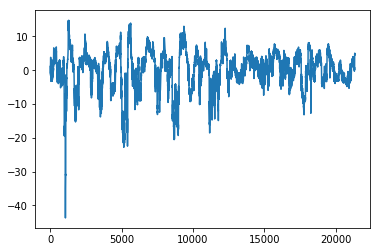

In [229]:
plt.plot(y_predict)

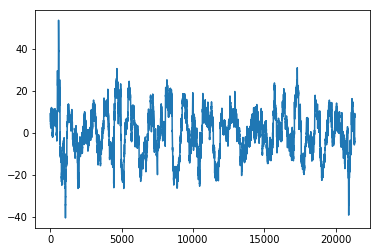

In [231]:
plt.plot(y)

In [232]:
df10 = df9.assign(predict = y_predict)

In [259]:
count = 0
count2 = 0
count3 = 0
count4 = 0
for value, prevValue, forecast, prevForecast, actual in zip(df10.drift_sv, df10.drift_sv.shift(1), df10.predict, df10.predict.shift(1), df10.drift_ahead):
    
    if (value > prevValue > 20) and (forecast < prevForecast < -20):
        
        count += 1
        
        if actual < -30:
            count2 += 1
            
    if (value < prevValue < -12) and (forecast > prevForecast > 12):
        
        count3 += 1
        
        if actual > 30:
            count4 += 1
        
#         print('Value is: %f' %value)
#         print('Forecast is: %f' %forecast)

print(count)
print(count2)
print(count3)
print(count4)

20
20
27
22


In [245]:
df10.tail()

,date,open,high,low,close,volume,drift_standard,vol,drift,drift_ahead,drift_s_ahead,drift_sv_ahead,drift_sv,predict
22302,2019-12-03 12:15:00+08:00,1.619525,1.619575,1.61890,1.61905,-1,-37.229167,4.481250,-41.25,-19.50,38.902604,8.681195,-8.307764,4.691866
22303,2019-12-03 12:20:00+08:00,1.619050,1.619050,1.61855,1.61865,-1,-41.874479,4.485937,-46.00,-16.75,41.591667,9.271566,-9.334610,5.055579
22304,2019-12-03 12:25:00+08:00,1.618650,1.619075,1.61865,1.61880,-1,-39.284375,4.487500,-43.50,-20.00,38.292708,8.533194,-8.754178,4.864251
22305,2019-12-03 12:30:00+08:00,1.618800,1.619350,1.61870,1.61910,-1,-36.205208,4.490104,-40.50,-23.00,35.256250,7.851989,-8.063334,4.635091
22306,2019-12-03 12:35:00+08:00,1.619100,1.619350,1.61895,1.61925,-1,-34.134896,4.493229,-38.50,-24.50,33.727083,7.506201,-7.596963,4.482362


In [257]:
df10.to_csv('new_data.csv')

## Drift - Ichi Dispersion

In [260]:
def ICHIMOKU(df):
        """
        The Ichimoku Cloud, also known as Ichimoku Kinko Hyo, is a versatile indicator that defines support and resistance,
        identifies trend direction, gauges momentum and provides trading signals.
        Ichimoku Kinko Hyo translates into “one look equilibrium chart”.
        """
        mult = 3

        tenkan_sen = pd.Series(
            (
                df["high"].rolling(window=9 * mult).mean()
                + df["low"].rolling(window=9 * mult).mean()
            )
            / 2,
            name="TENKAN",
        )  ## conversion line
        kijun_sen = pd.Series(
            (
                df["high"].rolling(window=26* mult).mean()
                + df["low"].rolling(window=26* mult).mean()
            )
            / 2,
            name="KIJUN",
        )  ## base line

        senkou_span_a = pd.Series(
            ((tenkan_sen + kijun_sen) / 2), name="senkou_span_a"
        )  ## Leading span
        senkou_span_b = pd.Series(
            (
                (
                    df["high"].rolling(window=52 * mult).mean()
                    + df["low"].rolling(window=52 * mult).mean()
                )
                / 2
            ),
            name="SENKOU",
        )
        chikou_span = pd.Series(
            df["close"].shift(-26 * mult).rolling(window=26 * mult).mean(), name="CHIKOU"
        )
        
        temp = pd.concat([tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span], axis=1)
        df = df.join(temp)


        return df

In [261]:
def generate_signals(dataframe):

  ichi_period = 240
  window = 240

  df0 = dataframe
  ichi = round(df0.senkou_span_a - df0.SENKOU, 6)
  df1 = df0.assign(signal = ichi.rolling(window=ichi_period).mean())

  df2 = df1.assign(lowerBand = (df1.signal.rolling(window=window).mean() + 2.5 * df1.signal.rolling(window=window).std()))
  df3 = df2.assign(upperBand = (df1.signal.rolling(window=window).mean() - 2.5 * df1.signal.rolling(window=window).std()))

  df4 = df3.assign(lowerBandTf = (df1.signal.rolling(window=window).mean() + 4.5 * df1.signal.rolling(window=window).std()))
  df5 = df4.assign(upperBandTf = (df1.signal.rolling(window=window).mean() - 4.5 * df1.signal.rolling(window=window).std()))

  return df5

In [262]:
df11 = ICHIMOKU(df10)

In [263]:
df12 = generate_signals(df11)

In [264]:
df12.tail()

,date,open,high,low,close,volume,drift_standard,vol,drift,drift_ahead,...,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,signal,lowerBand,upperBand,lowerBandTf,upperBandTf
22302,2019-12-03 12:15:00+08:00,1.619525,1.619575,1.61890,1.61905,-1,-37.229167,4.481250,-41.25,-19.50,...,1.622483,1.623655,1.623069,1.624113,NaN,-0.000648,0.000873,-0.001731,0.001914,-0.002773
22303,2019-12-03 12:20:00+08:00,1.619050,1.619050,1.61855,1.61865,-1,-41.874479,4.485937,-46.00,-16.75,...,1.622285,1.623582,1.622933,1.624065,NaN,-0.000648,0.000861,-0.001729,0.001897,-0.002765
22304,2019-12-03 12:25:00+08:00,1.618650,1.619075,1.61865,1.61880,-1,-39.284375,4.487500,-43.50,-20.00,...,1.622081,1.623511,1.622796,1.624022,NaN,-0.000648,0.000850,-0.001726,0.001880,-0.002756
22305,2019-12-03 12:30:00+08:00,1.618800,1.619350,1.61870,1.61910,-1,-36.205208,4.490104,-40.50,-23.00,...,1.621886,1.623441,1.622664,1.623984,NaN,-0.000649,0.000838,-0.001723,0.001862,-0.002748
22306,2019-12-03 12:35:00+08:00,1.619100,1.619350,1.61895,1.61925,-1,-34.134896,4.493229,-38.50,-24.50,...,1.621713,1.623372,1.622542,1.623948,NaN,-0.000650,0.000826,-0.001720,0.001844,-0.002739


Text(0,0.5,'Drift Ahead')

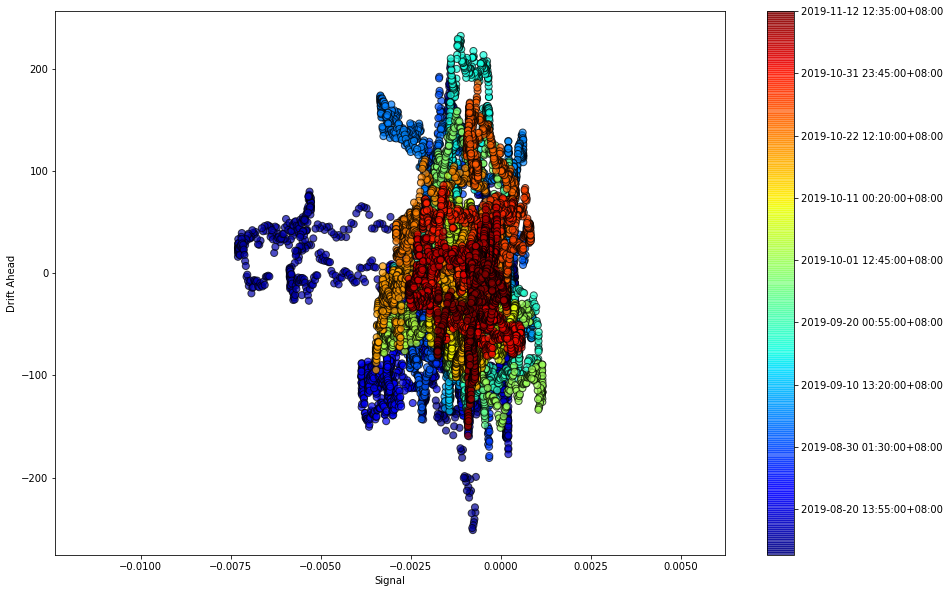

In [266]:
# visualize the correlation between assest prices over time
fig = plt.figure(figsize=(15,10));
cm = plt.cm.get_cmap('jet')
dates = [p for p in df12['date'][::len(df12['date'])//10]]
colors = np.linspace(0.1, 1, len(df12))
sc = plt.scatter(df12.upperBand, df12.drift_ahead, s=50, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in df12['date'][::len(df12['date'])//10]]);
plt.xlabel('Signal')
plt.ylabel('Drift Ahead')

In [293]:
rho1 = df12['predict'].rolling(window=960).corr(df12['drift_ahead'])

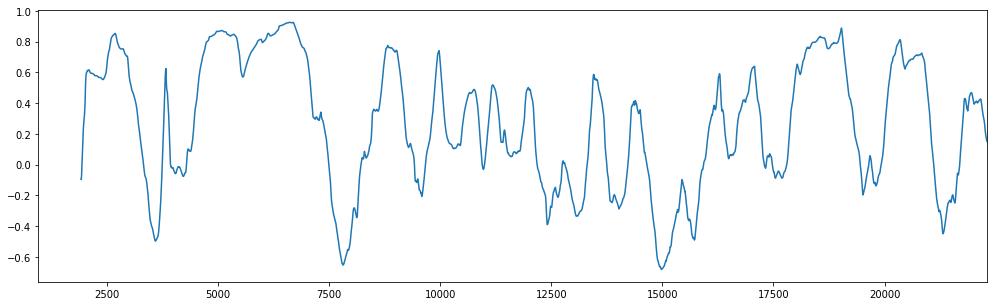

In [294]:
rho1.plot(figsize=(17,5));

In [282]:
rho1

959           NaN
960           NaN
961           NaN
962           NaN
963           NaN
           ...   
22302   -0.104301
22303   -0.105981
22304   -0.107473
22305   -0.108782
22306   -0.109988
Length: 21348, dtype: float64